<a href="https://colab.research.google.com/github/seungwon9201/Drug_detection-with-Deep-Learning/blob/main/Drug_detection_BERTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BERTweet모델**

In [41]:
from google.colab import drive
import pandas as pd

# 구글 드라이브를 마운트
drive.mount('/content/drive')

# 파일 경로 지
file_path = '/content/drive/My Drive/dataset_utf8_sig.csv'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
!pip install emoji==0.6.0

In [178]:
# CSV 파일을 pandas DataFrame으로 로드 (UTF-8-SIG로 인코딩 지정)
df = pd.read_csv(file_path, encoding='utf-8-sig')

df.head()


,text,label
0,☄ 텔✒ 레 ✒ 문♠ 의 ☃\n\nHappy b b o n g\n\n아이스작대기 \...,1.0
1,☀ 텔☢ 레 ❣ 문♣ 의 ✌\n\nHappy b b o n g\n\n아이스작대기 \...,1.0
2,↘텔레 KRBW24♨\n\n사기 걱정 NO ♦\n안전한 거래 ♈\n\n✈ 정량 샘플...,1.0
3,☀텔레 KRBW24↔\n\n사기 걱정 NO ☀\n안전한 거래 ☝\n\n✿ 착한딜러 ...,1.0
4,텔 레 i c e p i c k s\n\n☠ 퀄리티승부 ☀\n샘플 20만 아이스작대...,1.0


In [179]:
# 결측치 확인
def missing_values_info(df):
    missing_values = df.isnull().sum()
    print("\n결측치 정보:")
    print(missing_values[missing_values > 0])

missing_values_info(df)



결측치 정보:
text     1
label    2
dtype: int64


In [180]:
# 결측치가 있는 행 제거
df = df.dropna()

In [181]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import torch

# 텍스트 데이터 로드
#texts = df['Text'].tolist()
X = df['text']

# BERTweet 모델과 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")

def get_bertweet_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_texts = [str(text) for text in batch_texts]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_embeddings.cpu().numpy())
    return np.vstack(embeddings)


# 각 텍스트에 대해 BERT 임베딩을 계산
X_embeddings = get_bertweet_embeddings(X.tolist())

# 넘파이 배열로 변환
embeddings_array = np.array(X_embeddings)

# t-SNE 차원 축소
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# K-means 클러스터링 적용 (차원 축소된 데이터 사용)
n_clusters = 3  # 군집 수 설정
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(reduced_embeddings)


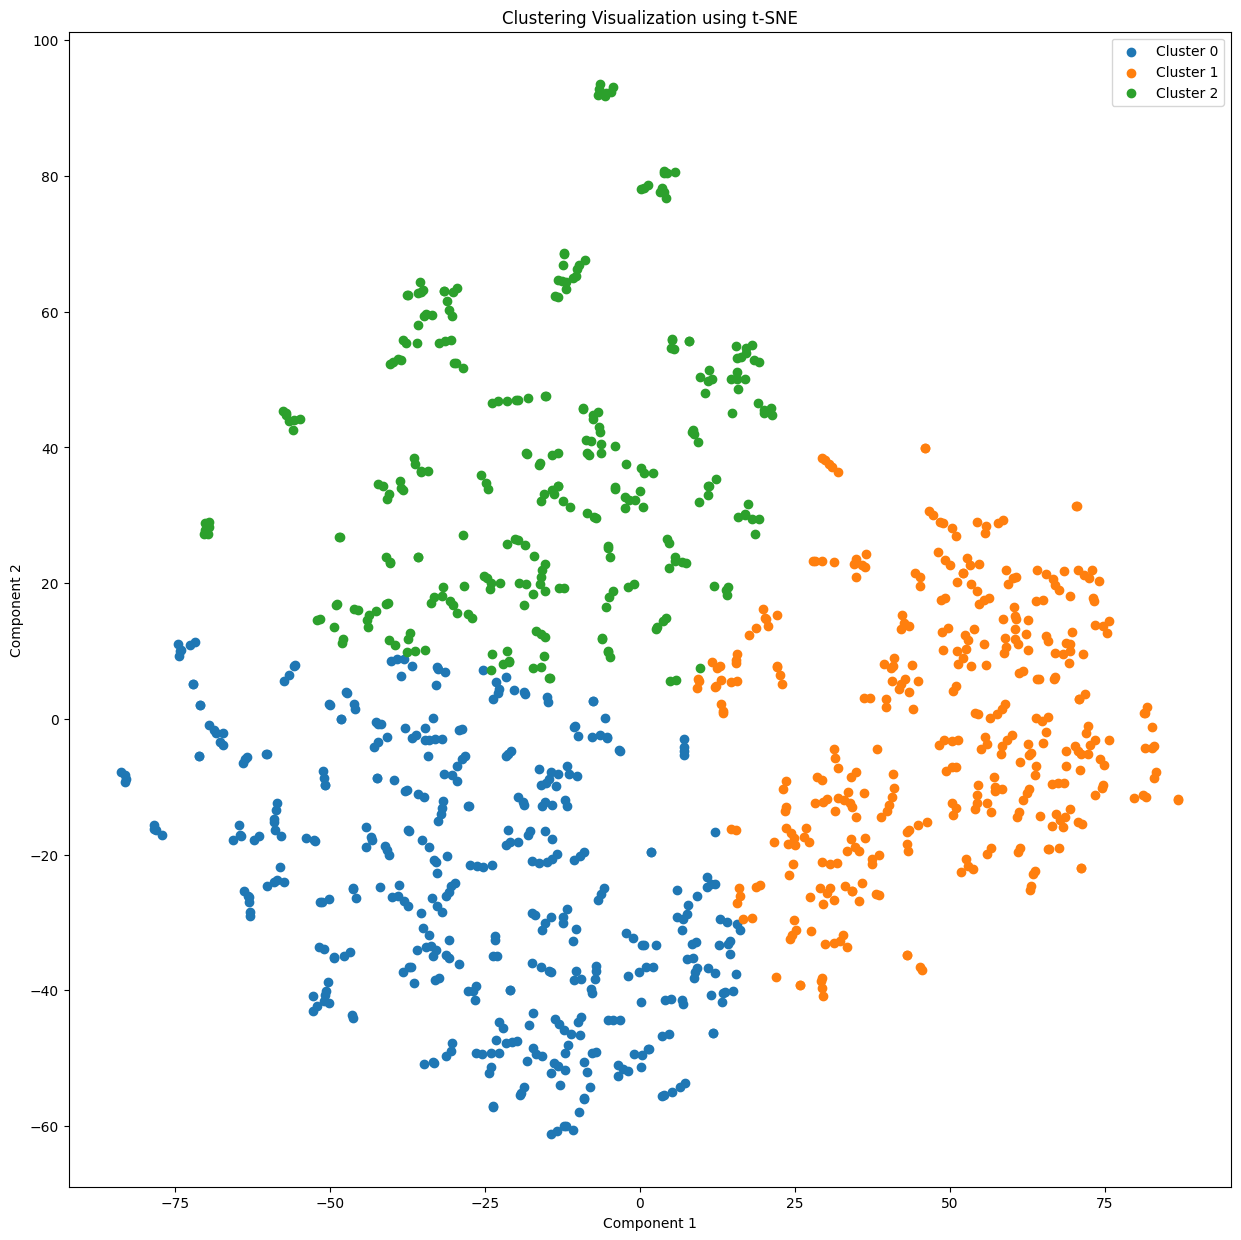

In [182]:
# 클러스터 시각화
def plot_clusters(reduced_embeddings, labels):
    plt.figure(figsize=(15, 15))
    for i, label in enumerate(set(labels)):
        plt.scatter(reduced_embeddings[labels == label, 0], reduced_embeddings[labels == label, 1], label=f'Cluster {label}')
    plt.title('Clustering Visualization using t-SNE')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# 클러스터 시각화 실행
plot_clusters(reduced_embeddings, predicted_labels)

# BERTweet 성능 분석

In [169]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
import numpy as np

# 1. BERTweet 모델 및 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")

# 2. CSV 파일 읽기
data = pd.read_csv('/content/drive/MyDrive/dataset_utf8_sig.csv')

# 3. 특징(X)과 라벨(y)로 분리
X = data['text']  # 'text' 컬럼을 입력 데이터로 사용
y = data['label']  # 'label' 컬럼을 타겟 변수로 설정

# 4. BERTweet 임베딩 벡터로 변환 함수 (배치 처리 추가)
def get_bertweet_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_texts = [str(text) for text in batch_texts]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_embeddings.cpu().numpy())
    return np.vstack(embeddings)

# 5. 텍스트 데이터를 BERTweet 임베딩 벡터로 변환
X_embeddings = get_bertweet_embeddings(X.tolist())

#Curse of Dimensionality 방지를 위한 dimension reduction ==> PCA // GridSearch

# 6. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# 7. XGBoost 모델로 다중 클래스 분류  #hyper-parameter tuning ==> RandomSearch
idx = ~np.isnan(y_train)
y_train = y_train[idx]
X_train = X_train[idx]

idx = ~np.isnan(y_test)
y_test = y_test[idx]
X_test = X_test[idx]


y_train = y_train.astype(int)

xgb_clf_basic = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf_basic.fit(X_train, y_train)

# 8. XGBoost 결과 예측
xgb_predictions_basic = xgb_clf_basic.predict(X_test)

# 9. 성능 평가 지표 계산
accuracy = accuracy_score(y_test, xgb_predictions_basic)
precision = precision_score(y_test, xgb_predictions_basic, average='weighted')
recall = recall_score(y_test, xgb_predictions_basic, average='weighted')
f1 = f1_score(y_test, xgb_predictions_basic, average='weighted')

# 10. 성능 지표 출력
print(f'XGBoost 모델 성능:')
print(f'정확도(Accuracy): {accuracy:.2f}')
print(f'정밀도(Precision): {precision:.2f}')
print(f'재현율(Recall): {recall:.2f}')
print(f'F1-score: {f1:.2f}')

# 11. 세부적인 성능 지표 보고서 출력 (클래스별)
print("\n클래스별 성능 보고서:")
print(classification_report(y_test, xgb_predictions_basic))



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:53:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 모델 성능:
정확도(Accuracy): 0.90
정밀도(Precision): 0.90
재현율(Recall): 0.90
F1-score: 0.90

클래스별 성능 보고서:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        47
         1.0       0.91      0.97      0.94       109
         2.0       0.89      0.79      0.84        62

    accuracy                           0.90       218
   macro avg       0.89      0.88      0.88       218
weighted avg       0.90      0.90      0.90       218



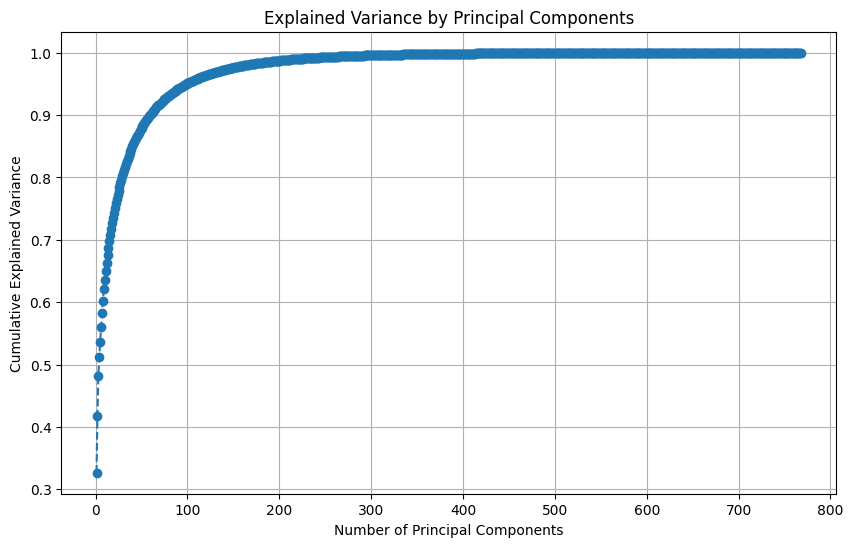

95%의 분산을 설명하는 주성분 개수: 100


In [170]:
# 12. PCA를 사용하여 차원 축소 수행
pca = PCA()
X_embeddings_pca = pca.fit_transform(X_embeddings)

# 13. 주성분 별 설명된 분산의 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 14. 설명된 분산의 누적 비율을 시각화하여 elbow point 찾기
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

# 15. 설명된 분산의 비율이 95%에 도달하는 지점 찾기
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"95%의 분산을 설명하는 주성분 개수: {n_components_95}")

In [173]:
# 16. 학습 데이터에서 결측치 제거
# y_train에서 결측치를 제거하고 그 인덱스를 X_train에 동일하게 적용
y_train_cleaned = y_train.dropna()
X_train_cleaned = X_train[~np.isnan(y_train)]

# PCA를 사용하여 학습 및 테스트 데이터를 95% 주성분으로 축소
pca = PCA(n_components=n_components_95)
X_train_reduced = pca.fit_transform(X_train_cleaned)
X_test_reduced = pca.transform(X_test)

# 17. 차원 축소 후 XGBoost 모델 재학습
xgb_clf_reduced = XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb_clf_reduced.fit(X_train_reduced, y_train_cleaned)

# 18. 축소된 데이터로 예측 수행
xgb_predictions_pca = xgb_clf_reduced.predict(X_test_reduced)

# 19. 성능 평가 지표 계산 (PCA 적용 후)
print("\n클래스별 성능 보고서 (BERTweet + PCA 적용 후):")
print(classification_report(y_test, xgb_predictions_pca))



클래스별 성능 보고서 (BERTweet + PCA 적용 후):
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85        47
         1.0       0.88      0.95      0.92       109
         2.0       0.90      0.74      0.81        62

    accuracy                           0.88       218
   macro avg       0.87      0.86      0.86       218
weighted avg       0.88      0.88      0.87       218



In [175]:
from sklearn.model_selection import RandomizedSearchCV

# 18. 랜덤 하이퍼파라미터 튜닝을 통한 XGBoost 모델 재학습
# 하이퍼파라미터 범위 설정
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 19. RandomizedSearchCV 설정 및 튜닝 수행
# PCA 적용 후 모델에 대해 랜덤 서치를 통한 최적 하이퍼파라미터 찾기
random_search = RandomizedSearchCV(xgb_clf_pca, param_distributions=param_dist, n_iter=20, scoring='f1_weighted', cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train_reduced, y_train)
xgb_clf_reduced = random_search.best_estimator_

# 20. 랜덤 하이퍼파라미터 튜닝 후 예측 수행
# 최적화된 모델로 예측 수행
xgb_predictions_reduced = xgb_clf_reduced.predict(X_test_reduced)

# 21. 성능 평가 지표 계산 (BERTweet + PCA + 랜덤 하이퍼파라미터 튜닝 후)
# 최종 모델 성능 출력
print("\n클래스별 성능 보고서 (BERTweet + PCA + 랜덤 하이퍼파라미터 튜닝 후):")
print(classification_report(y_test, xgb_predictions_reduced))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:03:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



클래스별 성능 보고서 (BERTweet + PCA + 랜덤 하이퍼파라미터 튜닝 후):
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92        47
         1.0       0.91      0.94      0.93       109
         2.0       0.93      0.81      0.86        62

    accuracy                           0.91       218
   macro avg       0.91      0.90      0.90       218
weighted avg       0.91      0.91      0.91       218



# **# 최종결과 정리**

# **기본 BERTweet 모델**

정확도(Accuracy): 0.90

# **BERTweet + PCA (차원 축소 후)**

정확도(Accuracy): 0.88


# **BERTweet + PCA + 랜덤 하이퍼파라미터 튜닝 후 XGBoost 모델**

정확도(Accuracy): 0.91

---


PCA와 같은 차원축소를 할 경우 차원이 줄어들면서 데이터의 교유한

*   PCA와 같은 차원축소를 할 경우 차원이 줄어들면서 데이터의 고유한 특징도 줄어들어 탐지율이 크게 저하될 수 있음
*   BERTweet은 기본 768차원의 모델로 차원의 저주가 발생할 가능성이 존재함.
*   본 실험에서는 PCA를 했음에도 탐지율의 변화가 2퍼센트 밖에 없었고 이를 통하여 차원의 수는 100차원으로 대폭 감소시킴
*   추가적으로 떨어진 성능을 향상시키기 위한 랜덤하이퍼파라미터 적용으로 기존의 모델보다 높아진 91퍼센의 성능을 보였다.


본 연구에서는 차원의 저주를 해결하여 계산량을 줄이는 것과 동시에 하이퍼파라미터 최적화를 통해 모델의 성능을 원래 모델 이상으로 향상시킨 것으로 마약판매게시글의 실시간 탐지를 위한 경량화 모델을 제안한다. .

**KoBERT 모델(EDA 및 모델 성능 분석)**

In [62]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from transformers import AutoTokenizer
from transformers import BertModel

file_path = '/content/drive/My Drive/dataset_utf8_sig.csv'

# CSV 파일을 pandas DataFrame으로 로드 (UTF-8-SIG로 인코딩 지정)
df2 = pd.read_csv(file_path, encoding='utf-8-sig')

# 결측치가 있는 행 제거
df2 = df2.dropna()

# 데이터 확인 (첫 5개 행 출력)
print(df.head())


                                                text  label
0  ☄ 텔✒ 레 ✒ 문♠ 의 ☃\n\nHappy b b o n g\n\n아이스작대기 \...    1.0
1  ☀ 텔☢ 레 ❣ 문♣ 의 ✌\n\nHappy b b o n g\n\n아이스작대기 \...    1.0
2  ↘텔레 KRBW24♨\n\n사기 걱정 NO ♦\n안전한 거래 ♈\n\n✈ 정량 샘플...    1.0
3  ☀텔레 KRBW24↔\n\n사기 걱정 NO ☀\n안전한 거래 ☝\n\n✿ 착한딜러 ...    1.0
4  텔 레 i c e p i c k s\n\n☠ 퀄리티승부 ☀\n샘플 20만 아이스작대...    1.0


In [63]:
tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1')
model = BertModel.from_pretrained('skt/kobert-base-v1')

# 텍스트 데이터를 KoBERT 임베딩 벡터로 변환 (배치 처리)
def get_kobert_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_texts = [str(text) for text in batch_texts]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
        with torch.no_grad():
            outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(cls_embeddings.cpu().numpy())
    return np.vstack(embeddings)

# 각 텍스트에 대해 KoBERT 임베딩을 계산
X_embeddings = get_kobert_embeddings(df2['text'].tolist())

# 넘파이 배열로 변환
embeddings_array = np.array(X_embeddings)

# t-SNE 차원 축소
print("T-SNE 변환 진행 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# K-means 클러스터링 적용 (차원 축소된 데이터 사용)
n_clusters = 3  # 군집 수 설정
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(reduced_embeddings)


T-SNE 변환 진행 중...


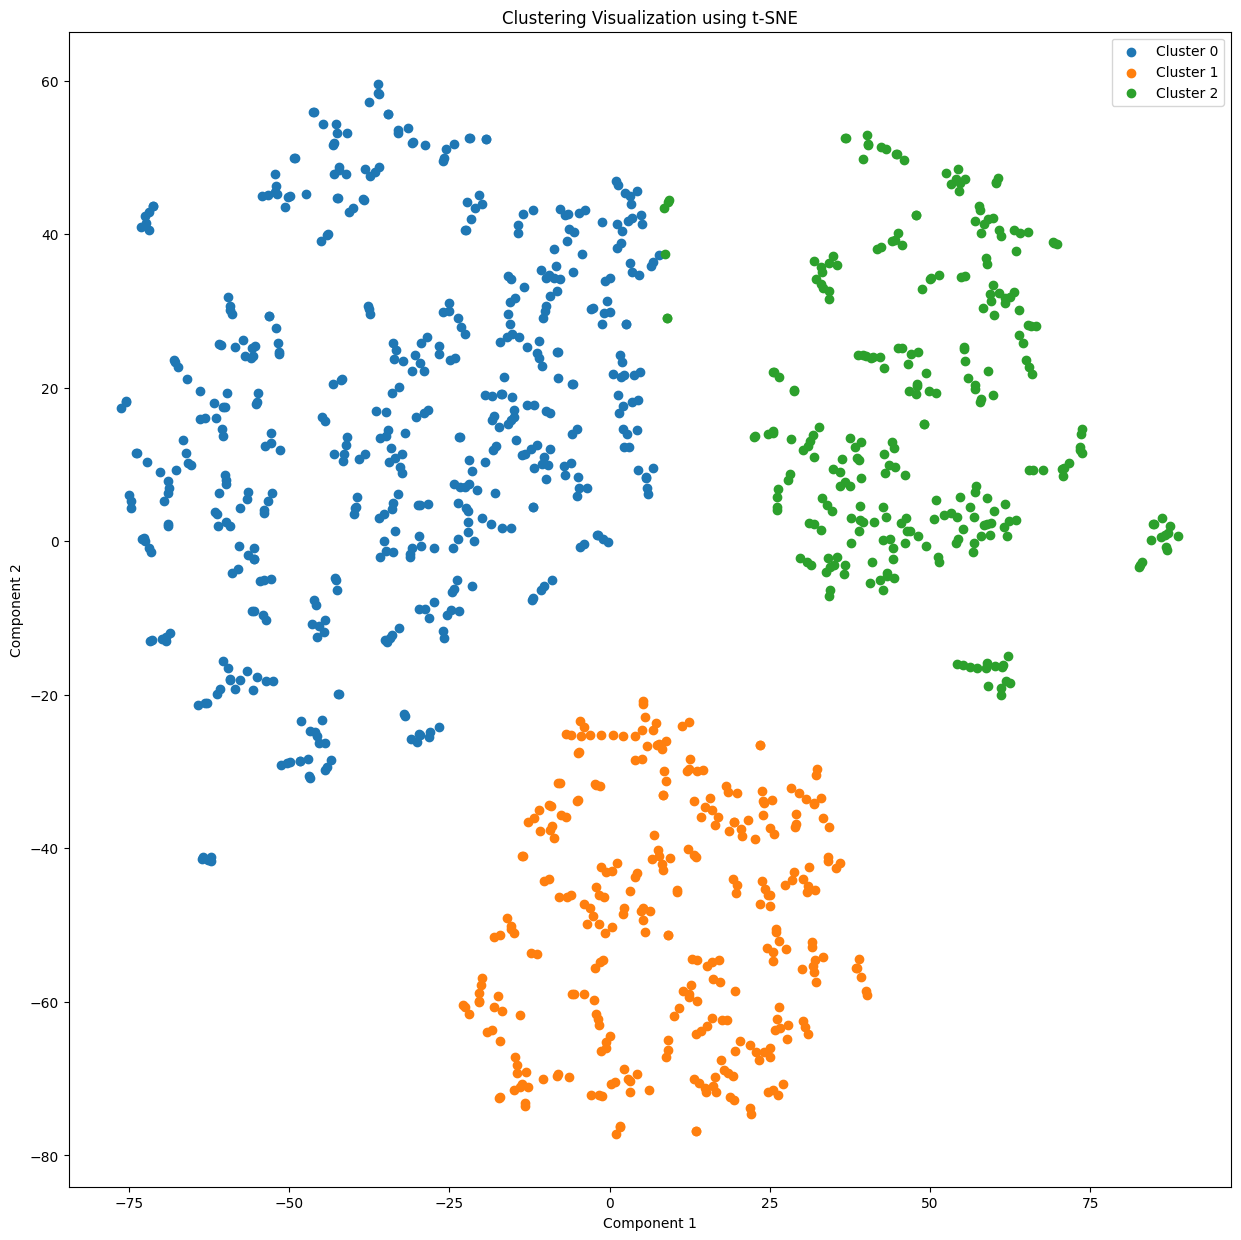

In [64]:
# 클러스터 시각화
def plot_clusters(reduced_embeddings, labels):
    plt.figure(figsize=(15, 15))
    for i, label in enumerate(set(labels)):
        plt.scatter(reduced_embeddings[labels == label, 0], reduced_embeddings[labels == label, 1], label=f'Cluster {label}')
    plt.title('Clustering Visualization using t-SNE')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.rc('font', family='DejaVu Sans')  # 폰트를 'DejaVu Sans'로 변경하여 오류 방지
    plt.show()

# 클러스터 시각화 실행
plot_clusters(reduced_embeddings, predicted_labels)

In [73]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import os


from google.colab import drive

# 구글 드라이브를 마운트
drive.mount('/content/drive')

# 파일 경로 지정
file_path = '/content/drive/My Drive/dataset_utf8_sig.csv'

# CSV 파일을 pandas DataFrame으로 로드 (UTF-8-SIG로 인코딩 지정)
df2 = pd.read_csv(file_path, encoding='utf-8-sig')

# 결측치가 있는 행 제거
df2 = df2.dropna()

# 데이터 확인 (첫 5개 행 출력)
print(df2.head())

# 결측치 확인
def missing_values_info(df2):
    missing_values = df2.isnull().sum()
    print("\n결측치 정보:")
    print(missing_values[missing_values > 0])

missing_values_info(df2)

# KoBERT 모델과 토크나이저 불러오기
print("KoBERT 모델 불러오기 및 학습 준비 중...")
tokenizer = AutoTokenizer.from_pretrained('skt/kobert-base-v1')
model = BertForSequenceClassification.from_pretrained('skt/kobert-base-v1', num_labels=3)

# Custom Dataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=self.max_length)
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }

# 데이터를 학습용과 평가용으로 분리
train_df, eval_df = train_test_split(df2, test_size=0.2, random_state=42)

# 학습 및 평가 데이터셋 준비
train_dataset = CustomDataset(train_df, tokenizer)
eval_dataset = CustomDataset(eval_df, tokenizer)

# Trainer를 사용해 KoBERT 모델 학습 준비
training_args = TrainingArguments(
    output_dir='./results',
    run_name='kobert_classification',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    report_to=[]  # wandb 비활성화
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

# 모델 학습
trainer.train()

# 모델 평가
eval_results = trainer.evaluate()
print(f"평가 결과: {eval_results}")

# 예측 수행 및 탐지율 계산
eval_predictions = trainer.predict(eval_dataset)
pred_labels = np.argmax(eval_predictions.predictions, axis=1)
print("분류 보고서:")
print(classification_report(eval_df['label'].values, pred_labels))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                text  label
0  ☄ 텔✒ 레 ✒ 문♠ 의 ☃\n\nHappy b b o n g\n\n아이스작대기 \...    1.0
1  ☀ 텔☢ 레 ❣ 문♣ 의 ✌\n\nHappy b b o n g\n\n아이스작대기 \...    1.0
2  ↘텔레 KRBW24♨\n\n사기 걱정 NO ♦\n안전한 거래 ♈\n\n✈ 정량 샘플...    1.0
3  ☀텔레 KRBW24↔\n\n사기 걱정 NO ☀\n안전한 거래 ☝\n\n✿ 착한딜러 ...    1.0
4  텔 레 i c e p i c k s\n\n☠ 퀄리티승부 ☀\n샘플 20만 아이스작대...    1.0

결측치 정보:
Series([], dtype: int64)
KoBERT 모델 불러오기 및 학습 준비 중...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.939200,0.924601
2,0.718400,0.727570
3,0.595900,0.556997


평가 결과: {'eval_loss': 0.5569970607757568, 'eval_runtime': 81.8682, 'eval_samples_per_second': 2.663, 'eval_steps_per_second': 0.171, 'epoch': 3.0}
분류 보고서:
              precision    recall  f1-score   support

         0.0       0.93      0.43      0.59        58
         1.0       0.87      0.95      0.91        97
         2.0       0.58      0.78      0.66        63

    accuracy                           0.76       218
   macro avg       0.79      0.72      0.72       218
weighted avg       0.80      0.76      0.75       218



마약 판매게시글의 경우 일반적인 게시글의 형태를 띄지않고 마약은어, 특수문자, 텔레그렘아이디, 문법을 고려하지 않는 문장 등 여러 복합적인 요소로 이루어져있음
한국어 데이터를 기반으로 학습하고 문장에서의 앞뒤 문맥을 파악하며 학습한 kobert모델은 위 실험에 적합하지 않다고 판단. 실제로 실험해본 결과 탐지율이 저조.

실험 초반 T-sne, K-means를 활용한 EDA과정을 진행하면서 오히려 BERTweet보다 마약 판매게시글을 눈에 뛰게 분류하는것을 보여서 성능이 더 높아지지 않을까 생각했으나, 고차원의 모델로의 학습이 진행되면서 kobert는 BERTweet처럼 SNS에서의 특화된 데이터를 학습한 모델이 아니기에 탐지율이 저조하다고 생각.